# Исследование объявлений о продаже квартир

**Ход исследования**

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

Перед анализом понадобится обзор данных, удаление пропусков, дубликатов, обработка аномальных значений и выявление параметров, оказывающих влияние на формирование цены.

Таким образом, исследование пройдёт в три этапа:
 1. Обзор данных.
 2. Предобработка данных.
 3. Исследовательский анализ данных.
 
 **Цель исследования** — установить параметры для определения рыночной стоимости объектов недвижимости в Санкт-Петербурге и соседних населённых пунктов, найти интнресные особенности и зависимости, которые существуют на рынке недвижимости. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 


### Обзор данных 

In [3]:
import pandas as pd

try:
    real_estate_data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    real_estate_data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')
    
real_estate_data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


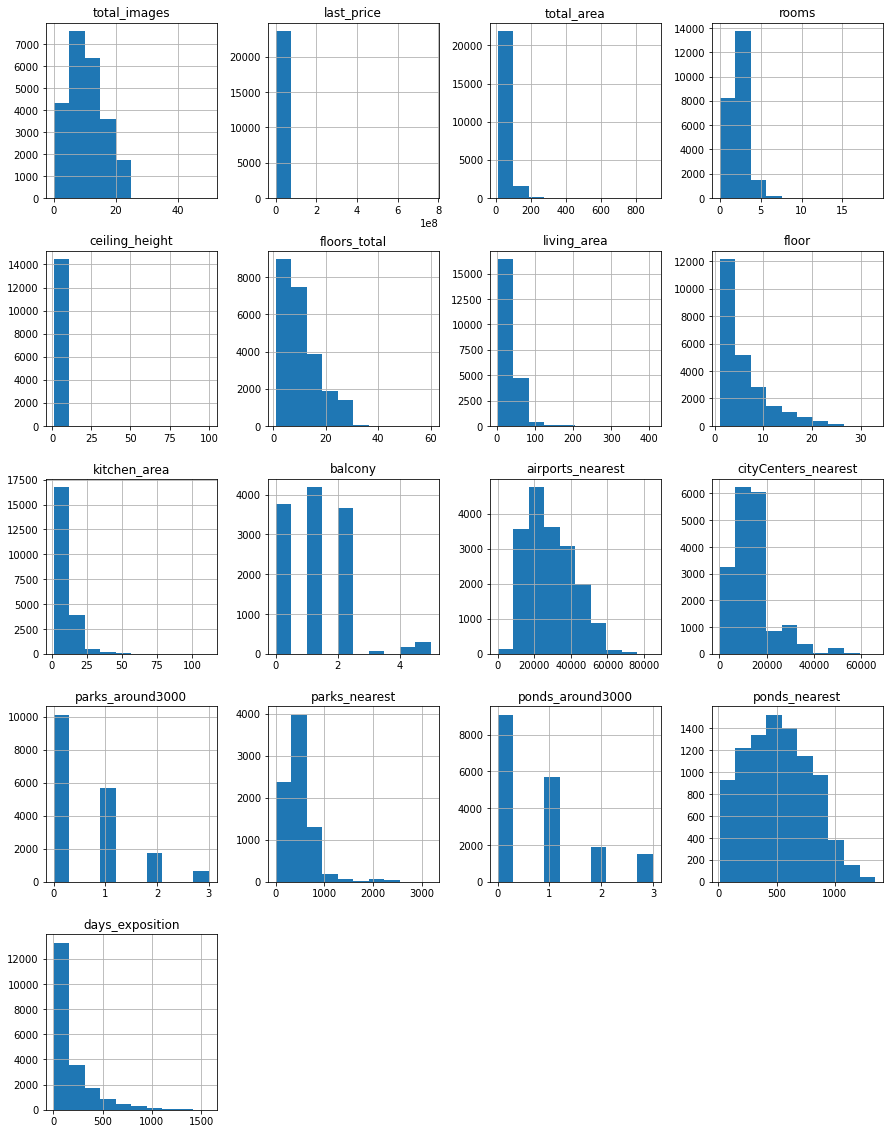

In [4]:
real_estate_data.hist(figsize=(15, 20));

### Предобработка данных

In [5]:
pd.DataFrame(round(real_estate_data.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,39.000000
floors_total,0.000000
living_area,8.000000
floor,0.000000
is_apartment,88.000000


In [6]:
real_estate_data = real_estate_data.rename(columns={'cityCenters_nearest': 'city_center_nearest'})

По характеру все пропуски можно разделить на две категории: пропуски, которые получились случайно, возможно ввиду невнимательности при заполнении объявлений (MCAR), и пропуски, возникшие при копировании, форматировании или каком-то другом процессе обработки данных (MNAR), такие пропуски мы трогать не будем, чтобы не понизить качество данных. Ко второй категории относятся, например, данные из колонок: "Расстояние до ближайшего аэропорта", "Расстояние до центра города", "Количество водоёмов в радиусе 3 км" и т.п.. К случайным пропускам можно отнести пропуски в столбцах: "Высота потолков", "Общее количество этажей в доме", "Жилая площадь", "Площадь кухни", "Количество балконов", "Апартаменты". От случайных пропусков мы попробуем избавиться там, где это возможно без искажения общей картины данных.

#### Удаление пропусков, изменение типов данных

In [7]:
real_estate_data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_center_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [8]:
real_estate_data['balcony'] = real_estate_data['balcony'].fillna('0').astype('int')

real_estate_data['is_apartment'] = real_estate_data['is_apartment'].fillna('True').astype('bool')

real_estate_data['floors_total'] = real_estate_data['floors_total'].fillna(real_estate_data['floors_total'].median()).astype('int')

real_estate_data['locality_name'] = real_estate_data['locality_name'].fillna('не указан')
    
real_estate_data = real_estate_data.dropna(subset=(['living_area']))    
                                  
real_estate_data = real_estate_data.dropna(subset=(['kitchen_area'])) 

real_estate_data['first_day_exposition'] = pd.to_datetime(real_estate_data['first_day_exposition'], format='%Y-%m-%dT' )


- Изменим тип данных в колонке "Апартаменты" на bool, так как в ней содержатся значения булева типа данных, тем самым избавимся от пропусков - убили двух зайцев. 
- Данные столбца "День публикации объявления" приведем к дате и времени. 
- Данные в столбце "Общее количество этажей" изменит на формат целых чисел, это явно ошибка, не может же быть 5.5 этажей.
- Данные в некоторых других столбцах переведем в формат целых чисел для дальнейшего удобства работы с ними.
- Пропуски в столбце "Общая площадь" и "Площадь кухни" можно удалить, так это они составляют 10 и 8% соответственно и их удаление не повлияет на ход анализа в дальнейшем.

</div>

#### Удаление дубликатов 

In [9]:
real_estate_data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Колпино', 'Гатчина',
       'поселок Мурино', 'деревня Фёдоровское', 'Выборг', 'Кронштадт',
       'Кировск', 'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'деревня Старая',
       'деревня Лесколово', 'село Путилово', 'Ивангород', 'Мурино',
       'Сланцы', 'Шлиссельбург', 'Сясьстрой', 'Никольское', 'Зеленогорск',
       'Сосновый Бор',

In [10]:
wrong_names = ['поселок городского типа Рябово', 'поселок Тельмана', 'поселок Лисий Нос','поселок Новый Свет']
correct_names = ['поселок Рябово', 'посёлок Тельмана', 'посёлок Лисий Нос', 'посёлок Новый Свет'] 
real_estate_data['locality_name'] = real_estate_data['locality_name'].replace(wrong_names, correct_names)

#### Обработка аномальных значений

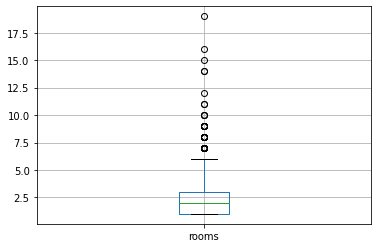

In [11]:
real_estate_data.boxplot('rooms');

In [12]:
real_estate_data = real_estate_data[(real_estate_data['rooms'] <= 6) & (real_estate_data['rooms'] != 0)]

In [13]:
real_estate_data.loc[real_estate_data['ceiling_height'] >= 20.0, 'ceiling_height'] = real_estate_data.loc[real_estate_data['ceiling_height'] >= 20.0, 'ceiling_height'] / 10
real_estate_data.loc[real_estate_data['ceiling_height'].isna(), 'ceiling_height'] = real_estate_data['ceiling_height'].median()

<AxesSubplot:>

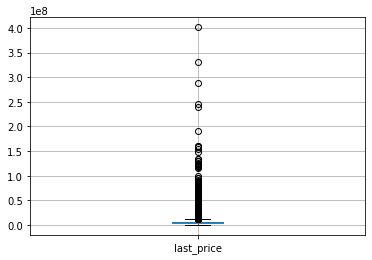

In [14]:
real_estate_data.boxplot('last_price')

In [15]:
real_estate_data['last_price'].sort_values()

8793         12190.0
17456       430000.0
9581        450000.0
5698        450000.0
17676       450000.0
            ...     
13749    240000000.0
16461    245000000.0
22831    289238400.0
1436     330000000.0
14706    401300000.0
Name: last_price, Length: 20904, dtype: float64

In [16]:
real_estate_data['last_price'] = real_estate_data.loc[real_estate_data['last_price'] > 430000, 'last_price'] 
real_estate_data['last_price'] = real_estate_data.loc[real_estate_data['last_price'] < 25000000, 'last_price']  
real_estate_data = real_estate_data.dropna(subset=['last_price'])

In [17]:
real_estate_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20521 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          20521 non-null  int64         
 1   last_price            20521 non-null  float64       
 2   total_area            20521 non-null  float64       
 3   first_day_exposition  20521 non-null  datetime64[ns]
 4   rooms                 20521 non-null  int64         
 5   ceiling_height        20521 non-null  float64       
 6   floors_total          20521 non-null  int64         
 7   living_area           20521 non-null  float64       
 8   floor                 20521 non-null  int64         
 9   is_apartment          20521 non-null  bool          
 10  studio                20521 non-null  bool          
 11  open_plan             20521 non-null  bool          
 12  kitchen_area          20521 non-null  float64       
 13  balcony         

In [18]:
pd.DataFrame(round(real_estate_data.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,0.000000
floors_total,0.000000
living_area,0.000000
floor,0.000000
is_apartment,0.000000


- В данных были замечены некоторые аномалии в столбце "Высота потолков", которые могут в дальнейшем сильно исказить расчёты. В связи с этим были обработаны значения, которые равны больше 20 метров, предположительно, была допущена ошибка при записи значений - и 20 метров на самом деле являются 2.0 метрами. 
- Столбец с количеством комнат был ограничен значениями от 1 до 6, так как большее количество комнат встречается крайне редко, но эти данные могут сказаться на качестве дальнейшего анализа.
- Некоторые значения параметра "Общая стоимость объекта" сильно выбиваются из общей картины, есть жилье, которое стоит 12000, что совсем не похоже на правду, а есть то, цена за которое составляет несколько сотен миллионов. Таких значений немного, поэтому их удаление не повлияет на качество анализа, и в дальнейшем наши расчёты, связанные с этим параметром, который является одним из основных в анализе, будут более точными. 

### Добавление новых столбцов

In [19]:
real_estate_data['one_meter_cost'] = (real_estate_data['last_price'] / real_estate_data['total_area']).astype('int')

real_estate_data['weekday'] = pd.DatetimeIndex(real_estate_data['first_day_exposition']).weekday

real_estate_data['month'] = pd.DatetimeIndex(real_estate_data['first_day_exposition']).month

#real_estate_data['month'] = real_estate_data['first_day_exposition'].astype('datetime64[M]')

real_estate_data['year'] = pd.DatetimeIndex(real_estate_data['first_day_exposition']).year

In [20]:
def floor_type_func(row):
    
    floors = row['floor']
    floors_total = row['floors_total']
    
    if floors == 1:
        return 'первый'
    if floors == floors_total:
            return 'последний'
    else:
        return 'другой'

real_estate_data['floor_type'] = real_estate_data.apply(floor_type_func, axis=1)
real_estate_data['floor_type'].unique()

array(['другой', 'первый', 'последний'], dtype=object)

In [21]:
real_estate_data['city_center_nearest'] = real_estate_data['city_center_nearest'] / 1000
real_estate_data['city_center_nearest'] = real_estate_data['city_center_nearest'].round()

In [22]:
real_estate_data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,one_meter_cost,weekday,month,year,floor_type
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,True,...,1.0,482.0,2.0,755.0,NaN,120370,3,3,2019,другой
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,True,...,0.0,NaN,0.0,NaN,81.0,82920,1,12,2018,первый
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,True,...,1.0,90.0,2.0,574.0,558.0,92785,3,8,2015,другой
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,True,...,2.0,112.0,1.0,48.0,121.0,100000,1,6,2018,другой
5,10,2890000.0,30.4,2018-09-10,1,2.65,12,14.4,5,True,...,NaN,NaN,NaN,NaN,55.0,95065,0,9,2018,другой


### Исследовательский анализ данных

#### Изучение параметров объектов

In [23]:
real_estate_data['total_area'].describe()

count    20521.000000
mean        57.624227
std         25.182228
min         14.000000
25%         40.000000
50%         51.900000
75%         68.000000
max        460.800000
Name: total_area, dtype: float64

In [24]:
real_estate_data['total_area'].value_counts()

45.00     372
42.00     331
60.00     311
44.00     304
31.00     297
         ... 
170.90      1
62.85       1
82.15       1
73.72       1
57.51       1
Name: total_area, Length: 1746, dtype: int64

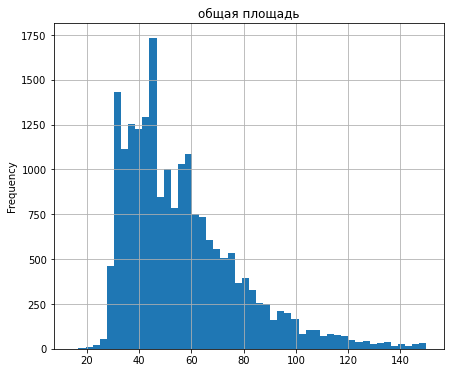

In [25]:
real_estate_data['total_area'].plot(title='общая площадь', kind='hist', bins=50, range=(14, 150), grid=True, figsize=(7,6));

In [26]:
real_estate_data['living_area'].value_counts().head(15)

18.0    824
17.0    640
30.0    584
16.0    453
20.0    448
28.0    414
31.0    369
29.0    311
32.0    310
19.0    306
27.0    303
15.0    293
43.0    227
40.0    216
42.0    209
Name: living_area, dtype: int64

In [27]:
real_estate_data['living_area'].describe()

count    20521.000000
mean        32.967664
std         16.873341
min          2.000000
25%         18.600000
50%         30.000000
75%         42.000000
max        279.600000
Name: living_area, dtype: float64

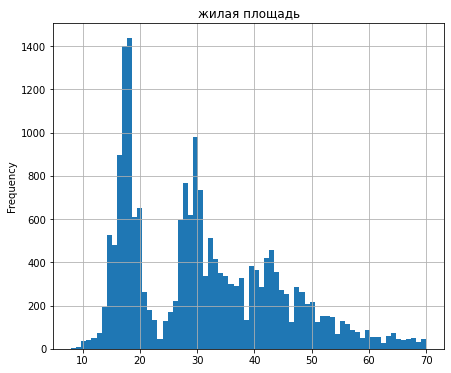

In [28]:
real_estate_data['living_area'].plot(title='жилая площадь', kind='hist', range=(8,70), bins=70, grid=True, figsize=(7,6));

In [29]:
real_estate_data['kitchen_area'].value_counts().head(15)

6.0     1274
10.0    1233
8.0     1094
9.0     1078
7.0     1049
11.0     786
12.0     629
8.5      411
5.5      398
14.0     359
5.0      351
15.0     326
13.0     311
6.3      293
6.2      282
Name: kitchen_area, dtype: int64

In [30]:
real_estate_data['kitchen_area'].describe()

count    20521.000000
mean        10.176324
std          4.930184
min          1.300000
25%          7.000000
50%          9.000000
75%         11.600000
max        100.700000
Name: kitchen_area, dtype: float64

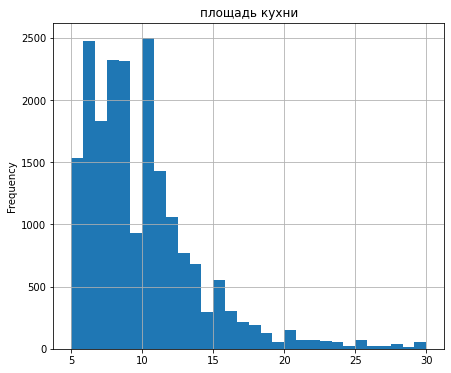

In [31]:
real_estate_data['kitchen_area'].plot(title='площадь кухни', kind='hist', range=(5,30), bins=30, grid=True, figsize=(7,6));

In [32]:
real_estate_data['last_price'].sort_values()

5698       450000.0
9581       450000.0
17676      450000.0
18867      470000.0
23484      470000.0
            ...    
18386    24800000.0
9561     24900000.0
4948     24900000.0
4199     24900000.0
18977    24900000.0
Name: last_price, Length: 20521, dtype: float64

In [33]:
real_estate_data['last_price'].value_counts().head(10)

4500000.0    308
3500000.0    254
4200000.0    245
4300000.0    237
4000000.0    236
3600000.0    229
3800000.0    222
4100000.0    212
3300000.0    212
3700000.0    209
Name: last_price, dtype: int64

In [34]:
real_estate_data['last_price'].describe()

count    2.052100e+04
mean     5.593318e+06
std      3.500474e+06
min      4.500000e+05
25%      3.490000e+06
50%      4.600000e+06
75%      6.590000e+06
max      2.490000e+07
Name: last_price, dtype: float64

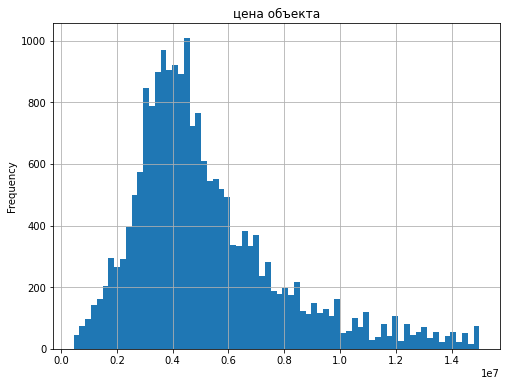

In [35]:
real_estate_data['last_price'].plot(title='цена объекта', kind='hist', range=(450000, 15000000), bins=70, grid=True, figsize=(8,6));

In [36]:
real_estate_data['rooms'].value_counts()

2    7088
1    7071
3    5131
4     962
5     206
6      63
Name: rooms, dtype: int64

In [37]:
real_estate_data['rooms'].describe()

count    20521.000000
mean         2.041616
std          0.959117
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: rooms, dtype: float64

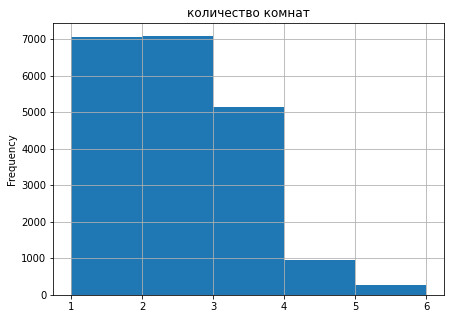

In [38]:
real_estate_data['rooms'].plot(title='количество комнат', kind='hist', bins=5, grid=True, figsize=(7,5));

In [39]:
real_estate_data['ceiling_height'].describe()

count    20521.000000
mean         2.690173
std          0.235954
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max         14.000000
Name: ceiling_height, dtype: float64

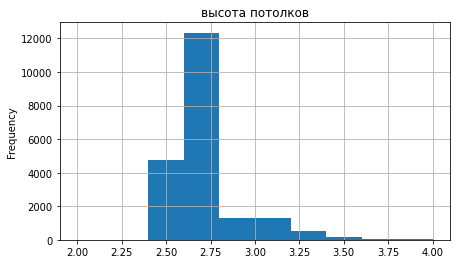

In [40]:
real_estate_data['ceiling_height'].plot(title='высота потолков', kind='hist', range=(2,4), bins=10, grid=True, figsize=(7,4));

In [41]:
real_estate_data['floor'].value_counts()

2     2896
3     2689
1     2534
4     2455
5     2274
6     1119
7     1047
8      945
9      934
10     592
11     458
12     458
13     311
14     294
15     286
16     274
17     187
18     151
19     113
21     105
22      97
20      96
23      85
24      52
25      33
26      22
27       8
28       1
29       1
32       1
30       1
33       1
31       1
Name: floor, dtype: int64

In [42]:
real_estate_data['floor'].describe()

count    20521.000000
mean         5.856488
std          4.840720
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

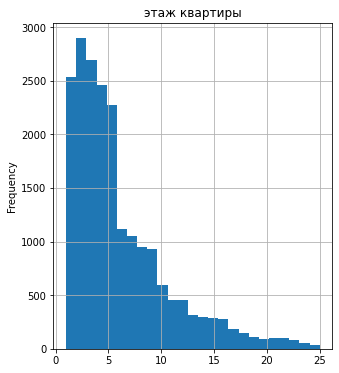

In [43]:
real_estate_data['floor'].plot(title='этаж квартиры', kind='hist', bins=25, range=(1,25), grid=True, figsize=(5,6));

In [44]:
real_estate_data['floor_type'].describe()

count      20521
unique         3
top       другой
freq       15096
Name: floor_type, dtype: object

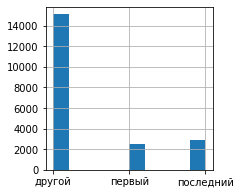

In [45]:
real_estate_data['floor_type'].hist(grid=True, figsize=(3,3));

In [46]:
real_estate_data['floors_total'].describe()

count    20521.000000
mean        10.612641
std          6.541701
min          1.000000
25%          5.000000
50%          9.000000
75%         15.000000
max         60.000000
Name: floors_total, dtype: float64

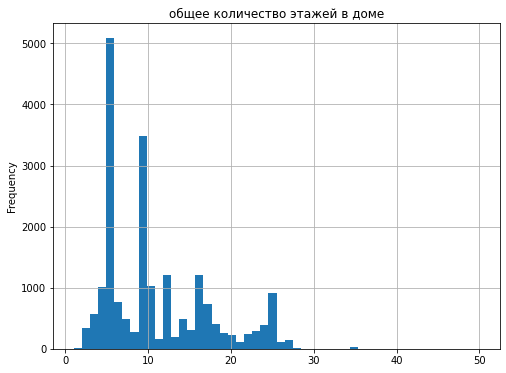

In [47]:
real_estate_data['floors_total'].plot(title='общее количество этажей в доме', kind='hist', range=(1,50), bins=50, grid=True, figsize=(8,6));

In [48]:
real_estate_data['city_center_nearest'].describe()

count    15875.000000
mean        14.467465
std          8.640351
min          0.000000
25%         10.000000
50%         13.000000
75%         16.000000
max         66.000000
Name: city_center_nearest, dtype: float64

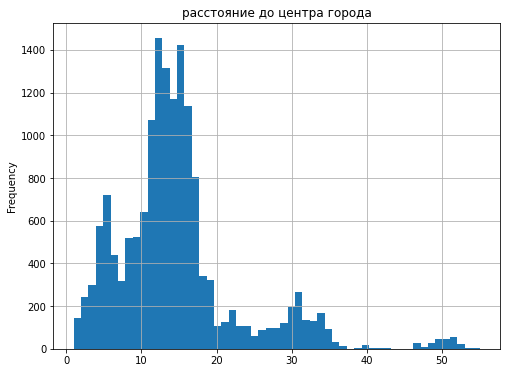

In [49]:
real_estate_data['city_center_nearest'].plot(title='расстояние до центра города', kind='hist', range=(1,55), bins=55, grid=True, figsize=(8,6));

In [50]:
real_estate_data['airports_nearest'].describe()

count    15858.000000
mean     28836.196179
std      12768.101379
min          0.000000
25%      18414.750000
50%      26812.000000
75%      37412.000000
max      84869.000000
Name: airports_nearest, dtype: float64

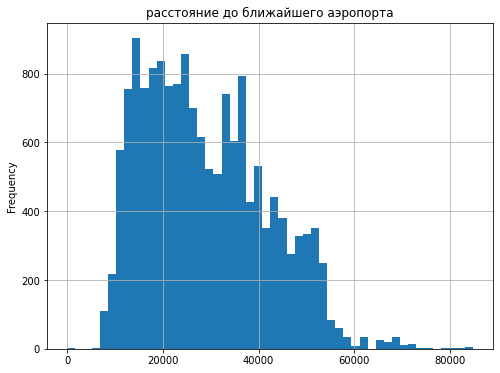

In [51]:
real_estate_data['airports_nearest'].plot(title='расстояние до ближайшего аэропорта', kind='hist', bins=50, grid=True, figsize=(8,6));

In [52]:
real_estate_data['parks_nearest'].describe()

count    6936.000000
mean      491.694925
std       338.928360
min         1.000000
25%       289.000000
50%       456.000000
75%       613.000000
max      3190.000000
Name: parks_nearest, dtype: float64

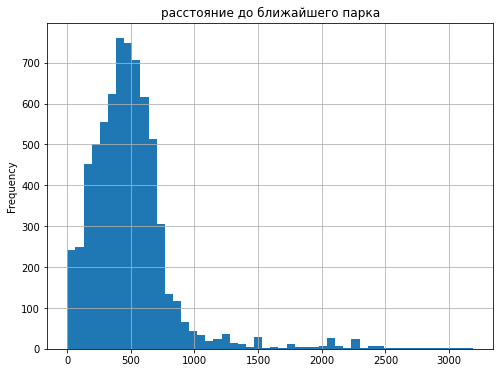

In [53]:
real_estate_data['parks_nearest'].plot(title='расстояние до ближайшего парка', kind='hist', bins=50, grid=True, figsize=(8,6));

In [54]:
real_estate_data['weekday'].value_counts()

3    3719
1    3657
4    3478
2    3445
0    3163
5    1633
6    1426
Name: weekday, dtype: int64

In [55]:
real_estate_data['weekday'].describe()

count    20521.000000
mean         2.550412
std          1.783016
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max          6.000000
Name: weekday, dtype: float64

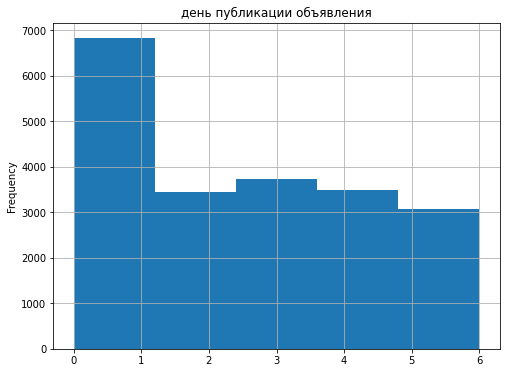

In [56]:
real_estate_data['weekday'].plot(title='день публикации объявления', kind='hist', bins=5, grid=True, figsize=(8,6));

In [57]:
real_estate_data['month'].value_counts()

2     2255
3     2230
11    2110
4     2106
10    1904
9     1790
6     1531
8     1509
7     1446
12    1299
1     1231
5     1110
Name: month, dtype: int64

In [58]:
real_estate_data['month'].describe()

count    20521.000000
mean         6.419424
std          3.465361
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         12.000000
Name: month, dtype: float64

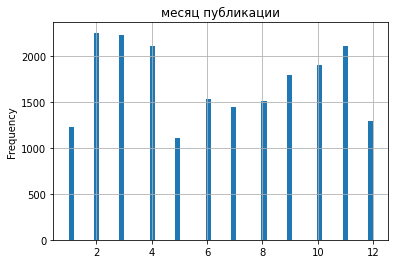

In [59]:
real_estate_data['month'].plot(title='месяц публикации', kind='hist', bins=60, grid=True, figsize=(6,4));

В ходе анализа параметров объектов были обнаружены следующие особенности:

- общая площадь продаваемых кварир в большинстве объявлений в среднем составляет 52 кв.м.. Площадь всех квартир варьируется от 12 до 507 кв.м., однако доля крайне маленьких и крайне больших значений довольно мала, большинств объектов недвижимости по площади составляют от 40 до 69 кв.м., данные в целом можно назвать однородными;
- что касается жилой площади, то судя по графику, в большинстве объявлениях жилая площадь составляет 17-18 или 30 кв. м.;
- площадь кухни в большинстве объявлений составляет от 6 до 10 кв.м., значения довольно однородны - медиана и среднее значения равны 10;
- общая стоимость объектов недвижимости варьируется от 430 тысяч до десятков миллионов, данные очень неоднородны, в начале анализа были зафиксированы значения с сотнями миллионов. Однако, основная часть всех объектов недвижимости стоит от 3.4 до 6.6 млн.;
- большинство квартир, выставленных на продажу - однокомнатные, а вот 5ти и 6ти комнатных крайне мало;
- средняя высота потолков составляет 2.7 метров, но стоит не забывать, что в столбце с данным параметром было много неккоректных данных,которые мы постарались привести в соответствие, до этого встречалась высота и 0 м., и 1 м., и 14, стоит обратить на это внимание;
- больше всего объявлений с квартирами на 2м этаже, и основная масса объявлений с объектами недвижимости с 1го по 5й этаж, а вот начиная с 10го этажа квартир встречается всё меньше и меньше. Скорее всего это связано с особенностями архитектуры города;
- расстояние до центра города в большинстве варианта варьируется от 14 до 16 км.;
- что касается растояния до аэропорта, то здесь можно заметить, что в основном жильё находится на расстоянии от 18 до 37 километров до аэропорта, но следует отменить, что данные в этом параметре не однородны;
- большинство объектов недвижимости выставленных на продажу находятся в 450-500 метрах от парковой зоны;
- в субботу и воскресенье меньше всего публикуется объявлений, например, в воскресенье почти в 3 раза меньше чем в четверг;
- больше всего публикаций в феврале, марте, апреле и ноябре, меньше всего люди выставляют объявления в мае, декабре и январе. Видимо, праздники всё же дело святое.

#### Как быстро продавались квартиры?

In [60]:
real_estate_data['days_exposition'].describe()

count    17750.000000
mean       183.311831
std        219.410066
min          1.000000
25%         44.000000
50%        101.000000
75%        236.000000
max       1580.000000
Name: days_exposition, dtype: float64

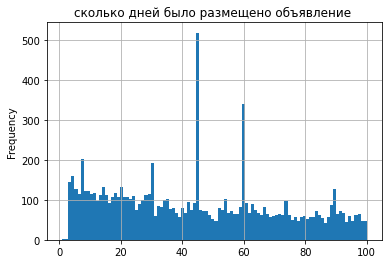

In [61]:
real_estate_data['days_exposition'].plot(title='сколько дней было размещено объявление ', kind='hist', bins=100, range=(1,100), grid=True);

In [62]:
real_estate_data['days_exposition'].value_counts().head()

45.0    518
60.0    340
7.0     201
30.0    193
4.0     159
Name: days_exposition, dtype: int64

In [63]:
days_exposition_mean = real_estate_data['days_exposition'].mean().round()
print('В среднем объявления размещаются', days_exposition_mean, 'дней.')
days_exposition_median = real_estate_data['days_exposition'].median()
print('Медиана равна', days_exposition_median, 'дней.')

В среднем объявления размещаются 183.0 дней.
Медиана равна 101.0 дней.


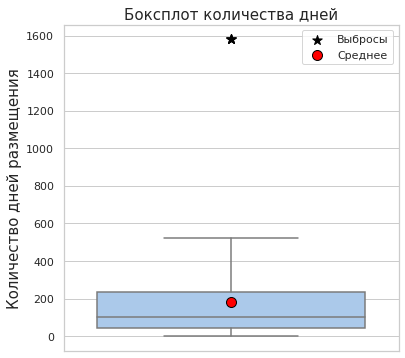

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize = (6, 6))
sns.set_theme(style="whitegrid")
sns.set_palette(palette="pastel")

sns.boxplot(y = real_estate_data['days_exposition'], showfliers = False)

plt.scatter(0, 1580, marker='*', s=100, color = 'black', label = 'Выбросы')
plt.scatter(0, 1580, marker='*', s=100, color = 'black')
plt.scatter(0, 1580, marker='*', s=100, color = 'black')
plt.scatter(0, days_exposition_mean, marker='o', s=100, color = 'red', edgecolors = 'black', label = 'Среднее')
plt.legend()

plt.ticklabel_format(axis='y', style='plain')
plt.ylabel('Количество дней размещения', fontsize=15)
plt.title("Боксплот количества дней", fontsize=15)
plt.show()

Анализируя продолжительность продажи квартиры, а точнее сколько дней было размещено объявление, сразу необходимо отметить, что данные очень неоднородны, количество значений варрируется от 1го дня до 4 лет. Диапазон самой распростроненной продолжительности размещения объявлений - от 45 до 232 дней. Среднее количество дней размещения объявлений (181 день) и медиана (96  дней) отличаются почти вдвое, что еще раз говорит о наличии больших выбросов и сильном разбросе значений. В данной ситуации медиана точнее отражает реальную картину наиболее частых значений.
Наличие крайне "долгих" объявлений вполне может свидетельствовать о том, что объявления после продажи зачастую просто не снимаются пользователями и продолжают висеть до окончания оплаченного периода. Данная особенность может стать отличным поводом для улучшения сервиса по продажи недвижимости. Также на графике заметна интересная особенность - есть выбросы равные 45 и 60 дням продолжительности размещения объявлений, может конечно это и совпадение, но лучше всё же проверить эту аномалию.

#### Какие факторы влияют на стоимость объекта?

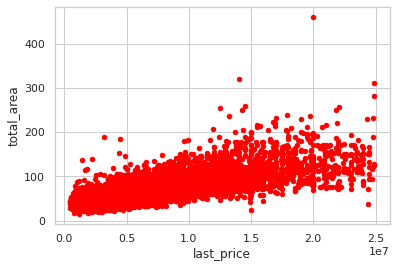

In [65]:
real_estate_data.plot(x='last_price', y='total_area', kind='scatter',color='red', alpha=1);

In [66]:
real_estate_data['total_area'].corr(real_estate_data['last_price'])

0.7787293628798282

С увеличением площади квартиры увеличивается стоимость, коэффициент корреляции этих двух параметров равен 0,7.

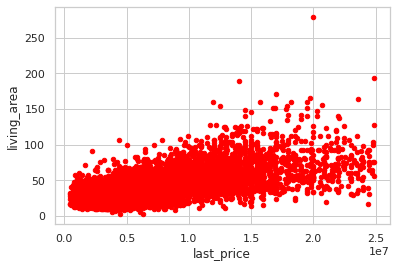

In [67]:
real_estate_data.plot(x='last_price', y='living_area', kind='scatter', color='red', alpha=1);

In [68]:
real_estate_data['living_area'].corr(real_estate_data['last_price'])

0.6665625603520269

С увеличением жилой площади увеличивается стоимость помещения, коэффициент корреляции равен 0,6, зависимость есть,но не такая явная.

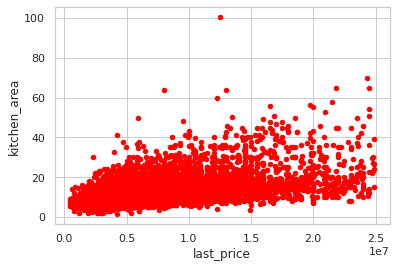

In [69]:
real_estate_data.plot(x='last_price', y='kitchen_area', kind='scatter', color='red', alpha=1);

In [70]:
real_estate_data['kitchen_area'].corr(real_estate_data['last_price'])

0.5930256792512633

Площадь кухни в свою очередь еще менее заметно влияет на стоимость объекта недвижимости, но зависимость всё же прослеживается - чем больше площадь кухни, тем больше стоимость жилья (коэффициент корреляции равен 0,5).

In [71]:
last_price_rooms_corr = real_estate_data.pivot_table(index='rooms', values='last_price', aggfunc=['count', 'mean'])
last_price_rooms_corr.columns = ['total','average_price']
last_price_rooms_corr.sort_values('rooms').reset_index()

,rooms,total,average_price
0,1,7071,3.815679e+06
1,2,7088,5.406418e+06
2,3,5131,7.165209e+06
3,4,962,9.647974e+06
4,5,206,1.208598e+07
5,6,63,1.497426e+07


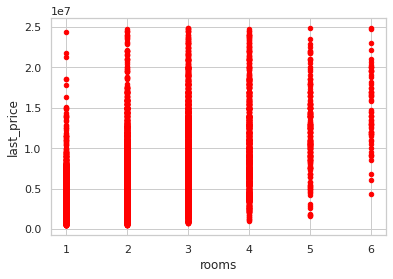

In [72]:
real_estate_data.plot(x='rooms', y='last_price', kind='scatter', color='red', alpha=1);

Зависимость стоимости жилья от количества комнат имеет обратный характер, наблюдается отрицательная корреляция. Чем меньше комнат, тем ниже средняя стоимость квартиры.

In [73]:
last_price_floor_type_corr = real_estate_data.pivot_table(index='floor_type', values='last_price')
last_price_floor_type_corr.columns = ['average_price']
last_price_floor_type_corr.sort_values('average_price').reset_index()

,floor_type,average_price
0,первый,4.474994e+06
1,последний,5.300333e+06
2,другой,5.837148e+06


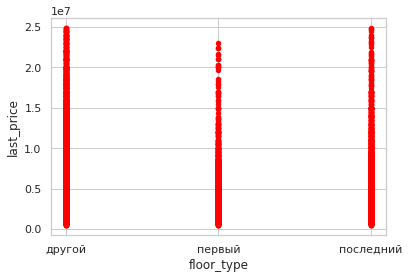

In [74]:
real_estate_data.plot(x='floor_type', y='last_price', kind='scatter', color='red', alpha=1);

Если рассматривать квартиры на первом этаже, то они значительно дешевле. Средняя стоимость квартир на певом этаже - 4.7 млн, в то время как на других этажах она равна 6.6 млн. На последниъх этажах квартиры немного дороже - 6.7 млн.

In [75]:
last_price_weekday_corr = real_estate_data.pivot_table(index='weekday', values='last_price', aggfunc=('count','mean'))
last_price_weekday_corr.columns = ['total','average_price']
last_price_weekday_corr.sort_values('average_price').reset_index()

,weekday,total,average_price
0,5,1633,5.372432e+06
1,6,1426,5.476232e+06
2,4,3478,5.541927e+06
3,1,3657,5.602999e+06
4,0,3163,5.607680e+06
5,2,3445,5.651297e+06
6,3,3719,5.707822e+06


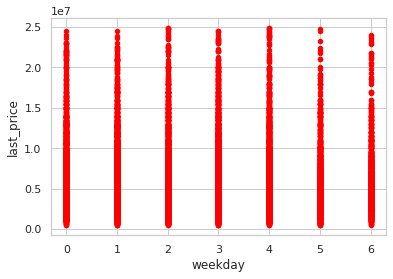

In [76]:
real_estate_data.plot(x='weekday', y='last_price', kind='scatter', color='red', alpha=1);

Зависимость стоимости квартиры от дня публикации объявления прослеживается нечетко, но интересные наблюдения всё же есть: воскресные объявления считаются самыми "дешевыми", например, средняя цена объявлений опубликованных в воскресенье на 400 тысяч ниже цены объявлений четверга.

In [77]:
last_price_month_corr = real_estate_data.pivot_table(index='month', values='last_price', aggfunc=('count', 'mean'))
last_price_month_corr.columns = ['total','average_price']
last_price_month_corr.sort_values('average_price', ascending=False).reset_index()

,month,total,average_price
0,9,1790,5.761321e+06
1,12,1299,5.727086e+06
2,4,2106,5.657257e+06
3,1,1231,5.630036e+06
4,2,2255,5.625845e+06
5,11,2110,5.607581e+06
6,3,2230,5.593002e+06
7,5,1110,5.590728e+06
8,7,1446,5.563447e+06
9,8,1509,5.482112e+06


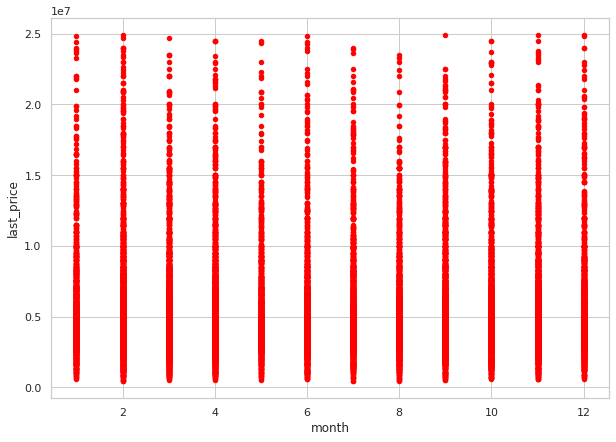

In [78]:
real_estate_data.plot(x='month', y='last_price', kind='scatter', color='red', alpha=1, figsize=(10,7));

Интересная закономерность: в июне жильё в среднем на 400 тысяч дешевле чем в сентябре и декабре. В принципе, начиная с мая  цены на недвижимость постепенно снижаются до августа.

In [79]:
last_price_year_corr = real_estate_data.pivot_table(index='year', values='last_price', aggfunc=('count','mean'))
last_price_year_corr.columns = ['total','average_price']
last_price_year_corr.sort_values('average_price').reset_index()

,year,total,average_price
0,2017,7228,5.468350e+06
1,2018,7163,5.486789e+06
2,2016,2474,5.571892e+06
3,2019,2522,5.832510e+06
4,2015,1019,6.337970e+06
5,2014,115,8.700298e+06


<AxesSubplot:xlabel='year', ylabel='last_price'>

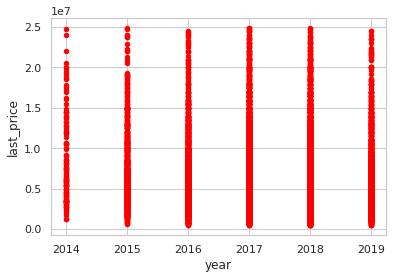

In [80]:
real_estate_data.plot(x='year', y='last_price', kind='scatter', color='red', alpha=1)

 В 2014 году средняя стоимость квартир была самой высокой из анализируемых лет и составила 1.2 млрд. Далее вплоть до 2019 года средняя стоимость жилья постепенно снижалась, но в 2019 возрасла на 700 тысяч по сравнению с 2018 годом. А вот самых продаваемых квартир в 2014 году было меньше - всего 115 объявлений, в 2015 году число объявлений выросло до 1000. В 2016 их количество достигло 2500, в 2017 и 2018 годах объявлений было уже 7500. В 2019 объявлений стало снова 2500, но это может быть связано с тем, что на момент выгрузки данных, год еще не закончился, эту информацию необходимо проверить.

В процессе анализа основных параметров были выявлены следующие закономерности в той или иной степени оказывающие влияние на общую стоимость объекта недвижимости:
- С увеличением площади квартиры увеличивается стоимость, коэффициент корреляции этих двух параметров равен 0,7.
- Похожая зависимость и от жилой площади помещения, но уже меньше, коэффициент равен 0,6.
- Площадь кухни в свою очередь еще менее заметно влияет на стоимость объекта недвижимости, но зависимость всё же прослеживается - чем больше площадь кухни, тем больше стоимость жилья (коэффициент корреляции равен 0,5).
- Зависимость стоимости жилья от количества комнат имеет обратный характер, наблюдается отрицательная корреляция. Чем меньше комнат, тем ниже средняя стоимость квартиры.
- Если рассматривать квартиры на первом этаже, то они значительно дешевле. Средняя стоимость квартир на певом этаже - 4.7 млн, в то время как на других этажах она равна 6.6 млн. На последниъх этажах квартиры немного дороже - 6.7 млн.
- Зависимость стоимости квартиры от дня публикации объявления прослеживается нечетко, но интересные наблюдения всё же есть: воскресные объявления считаются самыми "дешевыми", например, средняя цена объявлений опубликованных в воскресенье на 400 тысяч ниже цены объявлений четверга.
- Интересная закономерность: в июне жильё в среднем на 400 тысяч дешевле чем в сентябре и декабре. В принципе, начиная с мая  цены на недвижимость постепенно снижаются до августа.
- Что касается года, в котором было опубиковано объявление, можно отметить, что в 2014 году средняя стоимость квартир была самой высокой из анализируемых лет и составила 1.2 млрд. Далее вплоть до 2019 года средняя стоимость жилья постепенно снижалась, но в 2019 возрасла на 700 тысяч по сравнению с 2018 годом. А вот самых продаваемых квартир в 2014 году было меньше - всего 115 объявлений, в 2015 году число объявлений выросло до 1000. В 2016 их количество достигло 2500, в 2017 и 2018 годах объявлений было уже 7500. В 2019 объявлений стало снова 2500, но это может быть связано с тем, что на момент выгрузки данных, год еще не закончился, эту информацию необходимо проверить.

#### Средняя цена квадратного метра 

In [81]:
real_estate_data['meter_avg_price'] = real_estate_data['last_price'] / real_estate_data['total_area']

In [82]:
meter_cost_pivot = real_estate_data.pivot_table(index='locality_name', values='meter_avg_price', aggfunc=('median','count'))
meter_cost_pivot.columns = ['total_ads', 'one_meter_avg']
meter_cost_pivot.sort_values('total_ads',ascending=False).round().head(10).reset_index()

,locality_name,total_ads,one_meter_avg
0,Санкт-Петербург,13619,103346.0
1,посёлок Мурино,402,84923.0
2,посёлок Шушары,393,77273.0
3,Всеволожск,357,65789.0
4,Пушкин,331,99987.0
5,Колпино,321,74722.0
6,Гатчина,290,67746.0
7,посёлок Парголово,288,92272.0
8,деревня Кудрово,226,91715.0
9,Выборг,190,58357.0


In [83]:
meter_cost_pivot.sort_values('one_meter_avg', ascending=False).head(10)

,total_ads,one_meter_avg
locality_name,,
деревня Бор,1,105539.261570
Санкт-Петербург,13619,103346.442308
Зеленогорск,23,100000.000000
Пушкин,331,99987.179487
Кудрово,152,99761.330057
Сестрорецк,166,99719.035988
посёлок Парголово,288,92271.978022
деревня Кудрово,226,91715.116279
деревня Мистолово,9,90229.885057


In [84]:
max_meter_cost = meter_cost_pivot.query('one_meter_avg > 90000 & total_ads >= 237')
max_meter_cost.sort_values('one_meter_avg',ascending=False).round().head(10).reset_index()

,locality_name,total_ads,one_meter_avg
0,Санкт-Петербург,13619,103346.0
1,Пушкин,331,99987.0
2,посёлок Парголово,288,92272.0


In [85]:
min_meter_cost = meter_cost_pivot.query('one_meter_avg <= 74000 & total_ads >= 237')
min_meter_cost.sort_values('one_meter_avg').round().head(10).reset_index()

,locality_name,total_ads,one_meter_avg
0,Всеволожск,357,65789.0
1,Гатчина,290,67746.0


Среди населённых пунктов с самой высокой стоимостью квадратного метра, их тех, в которых продается наибольшее количество объектов недвижимости, лидерами оказались города Санкт-Петербург, Пушкин, посёлок Парголово и деревня Кудрово. Стоимость квадратного метра жилья в этих населенных пунктах составляет в среднем 97 000 тысяч рублей.
Самый дешевый квадратный метр в Выборге, Всеволожске и Гатчине, в среднем он стоит 64 000 рублей.
Также важно отметить, что доля недвижимости, продаваемой в Санкт-Петербурге, значительно превышает остальные и составляет 66% от всех объявлений.

#### Средняя цена километра в Санкт-Петербурге

In [86]:
spb_km_price = (
    real_estate_data.query('locality_name == "Санкт-Петербург"')
    .pivot_table(index='city_center_nearest', values='meter_avg_price', aggfunc=('mean'))
    .round()
    .reset_index()
)
spb_km_price.columns = ['km_to_center', 'km_avg_price']
spb_km_price.sort_values('km_to_center')

,km_to_center,km_avg_price
0,0.0,125295.0
1,1.0,131543.0
2,2.0,126456.0
3,3.0,114086.0
4,4.0,121805.0
5,5.0,126915.0
6,6.0,126248.0
7,7.0,127079.0
8,8.0,123493.0
9,9.0,110910.0


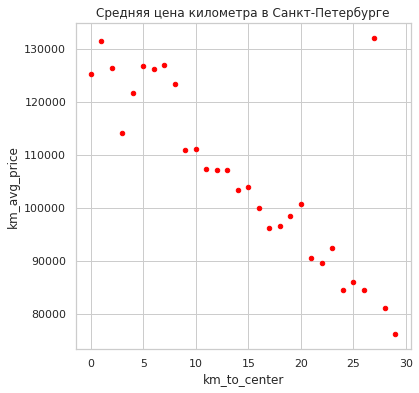

In [87]:
spb_km_price.plot(x='km_to_center', y='km_avg_price', kind='scatter', color='red', figsize=(6,6), title = 'Средняя цена километра в Санкт-Петербурге');

In [88]:
spb_km_price['km_to_center'].corr(spb_km_price['km_avg_price'])

-0.8080014532711594

Между удаленностью объекта недвижимости от центра Санкт- Петербурга и стоимостью квадратного метра наблюдается отрицательная корреляция, то есть, в подавляющем большинстве случаев, чем квартира ближе к центру, тем она дороже.

### Общий вывод

В результате анализа данных сервиса Яндекс Недвижимость — архива объявлений за несколько лет о продаже квартир в Санкт-Петербурге и соседних населённых пунктах, были найдены следующие интересные особенности и зависимости, которые существуют на рынке недвижимости:

- Лидерами среди публикаций объявлений оказались города Санкт-Петербург, Пушкин, посёлок Парголово и деревня Кудрово. Стоимость квадратного метра жилья в этих населенных пунктах составляет в среднем 97 000 тысяч рублей.

- Самый дешевый квадратный метр в Выборге, Всеволожске и Гатчине, в среднем он стоит 64 000 рублей. 

- Доля недвижимости, продаваемой в самом Санкт-Петербурге, значительно превышает остальные и составляет 66% от всех объявлений.

- В Санкт-Петербурге (хотя где иначе) чем квартира ближе к центру, тем она дороже.

- С увеличением площади квартиры увеличивается стоимость, коэффициент корреляции этих двух параметров равен 0,7.

- Продолжительность продажи квартиры, а точнее сколько дней было размещено объявление, варрируется от 1го дня до 4 лет. Чаще всего объявления "висят" от 45 до 232 дней. Наличие крайне "долгих" объявлений вполне может свидетельствовать о том, что объявления после продажи зачастую просто не снимаются пользователями и продолжают висеть до окончания оплаченного периода. Данная особенность может стать отличным поводом для улучшения сервиса по продажи недвижимости.

- Похожая зависимость и от жилой площади помещения, но уже меньше, коэффициент равен 0,6.

- Площадь кухни в свою очередь еще менее заметно влияет на стоимость объекта недвижимости, но зависимость всё же прослеживается - чем больше площадь кухни, тем больше стоимость жилья (коэффициент корреляции равен 0,5).

- Зависимость стоимости жилья от количества комнат имеет обратный характер, наблюдается отрицательная корреляция. Чем меньше комнат, тем ниже средняя стоимость квартиры.

- Если рассматривать квартиры на первом этаже, то они значительно дешевле. Средняя стоимость квартир на певом этаже - 4.7 млн, в то время как на других этажах она равна 6.6 млн. На последниъх этажах квартиры немного дороже - 6.7 млн.

- Воскресные объявления оказались самыми "дешевыми", например, средняя цена объявлений опубликованных в воскресенье на 400 тысяч ниже цены объявлений четверга. 

- Интересная закономерность: в июне жильё в среднем на 400 тысяч дешевле чем в сентябре и декабре. В принципе, начиная с мая  цены на недвижимость постепенно снижаются до августа.

- В 2014 году средняя стоимость квартир была самой высокой из анализируемых лет и составила 1.2 млрд. Далее вплоть до 2019 года средняя стоимость жилья постепенно снижалась, но в 2019 возрасла на 700 тысяч по сравнению с 2018 годом. А вот самых продаваемых квартир в 2014 году было меньше - всего 115 объявлений, в 2015 году число объявлений выросло до 1000. В 2016 их количество достигло 2500, в 2017 и 2018 годах объявлений было уже 7500. В 2019 объявлений стало снова 2500, но это может быть связано с тем, что на момент выгрузки данных, год еще не закончился, эту информацию необходимо проверить.

- Больше всего объявлений с квартирами на 2м этаже, и основная масса объявлений с объектами недвижимости с 1го по 5й этаж, а вот начиная с 10го этажа квартир встречается всё меньше и меньше. Скорее всего это связано с особенностями архитектуры города.

- В субботу и воскресенье меньше всего публикуется объявлений, например, в воскресенье почти в 3 раза меньше чем в четверг.

- Больше всего публикаций в феврале, марте, апреле и ноябре, меньше всего люди выставляют объявления в мае, декабре и январе. Видимо, праздники всё же дело святое.

